In [7]:
import tensorflow as tf
from matplotlib import pyplot as plt
from configuration import *

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.8.0


In [8]:
if tf.test.gpu_device_name():
    print("Default GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Not using a GPU - it will take long!!")

Default GPU: /device:GPU:0


In [9]:
print("DATASET_SIZE", DATASET_SIZE)
print("TRAIN_SIZE", TRAIN_SIZE)
print("TEST_SIZE", TEST_SIZE)

tf.random.set_seed(SEED)
print(TRAIN_SIZES)
print(TEST_SIZES)

DATASET_SIZE 294
TRAIN_SIZE 250
TEST_SIZE 44
[0, 0, 250, 0, 0]
[0, 0, 44, 0, 0]


In [10]:
from dataset_utils import create_paired_s2s_image_loader as create_image_loader

train_dataset = tf.data.Dataset.range(TRAIN_SIZE).shuffle(TRAIN_SIZE)
test_dataset = tf.data.Dataset.range(TEST_SIZE).shuffle(TEST_SIZE)

f2r_train_dataset = train_dataset.map(create_image_loader(2, 3, TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
f2r_train_dataset = f2r_train_dataset.batch(BATCH_SIZE)
f2r_test_dataset = test_dataset.map(create_image_loader(2, 3, TEST_SIZES, "test", False))
f2r_test_dataset = f2r_test_dataset.batch(BATCH_SIZE)


In [11]:
from denoising import ArtificialDenoisingAutoencoder

model = ArtificialDenoisingAutoencoder()

model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=["accuracy"])


In [12]:
def add_noise(image, noise_factor=0.2):
    noise_factor_on_alpha = tf.expand_dims(noise_factor * (image[..., 3] * 0.5 + 0.5), -1)
    return tf.clip_by_value(image + noise_factor_on_alpha * tf.random.normal(shape=image.shape[1:]), -1., 1.)

train_ds = f2r_train_dataset.map(lambda front, right: (add_noise(right), right))
test_ds = f2r_test_dataset.map(lambda front, right: (add_noise(right), right))

num_epochs = 200
training_history = model.fit(train_ds, epochs=num_epochs, shuffle=True, validation_data=test_ds,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)])

Epoch 1/200
63/63 [==============================] - 2s 23ms/step - loss: 0.1506 - accuracy: 0.1772 - val_loss: 0.0482 - val_accuracy: 0.5984
Epoch 2/200
63/63 [==============================] - 1s 20ms/step - loss: 0.0350 - accuracy: 0.3816 - val_loss: 0.0296 - val_accuracy: 0.3755
Epoch 3/200
63/63 [==============================] - 1s 22ms/step - loss: 0.0249 - accuracy: 0.4137 - val_loss: 0.0239 - val_accuracy: 0.4368
Epoch 4/200
63/63 [==============================] - 1s 20ms/step - loss: 0.0216 - accuracy: 0.4337 - val_loss: 0.0208 - val_accuracy: 0.4959
Epoch 5/200
63/63 [==============================] - 1s 20ms/step - loss: 0.0200 - accuracy: 0.4101 - val_loss: 0.0201 - val_accuracy: 0.3629
Epoch 6/200
63/63 [==============================] - 1s 19ms/step - loss: 0.0189 - accuracy: 0.4278 - val_loss: 0.0183 - val_accuracy: 0.5209
Epoch 7/200
63/63 [==============================] - 1s 21ms/step - loss: 0.0179 - accuracy: 0.4178 - val_loss: 0.0185 - val_accuracy: 0.2935
Epoch 

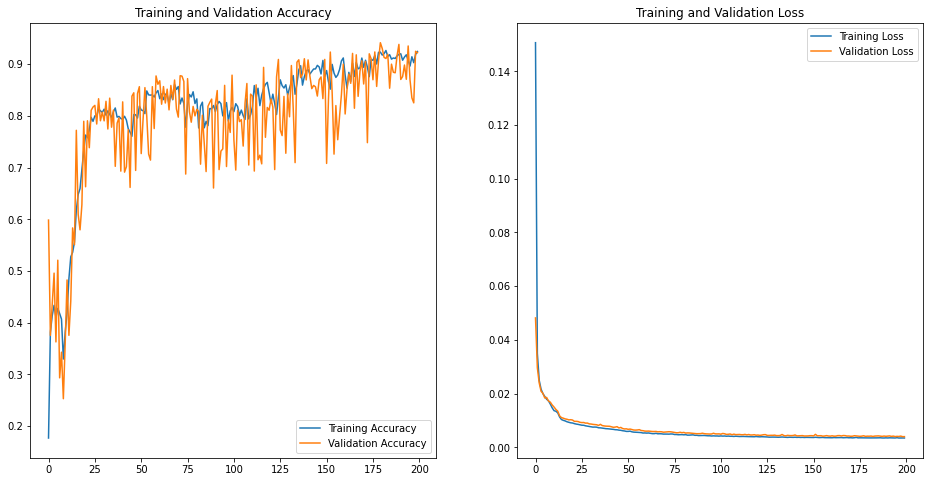

In [13]:
def show_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(acc)), acc, label='Training Accuracy')
    plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(loss)), loss, label='Training Loss')
    plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

show_accuracy(training_history)

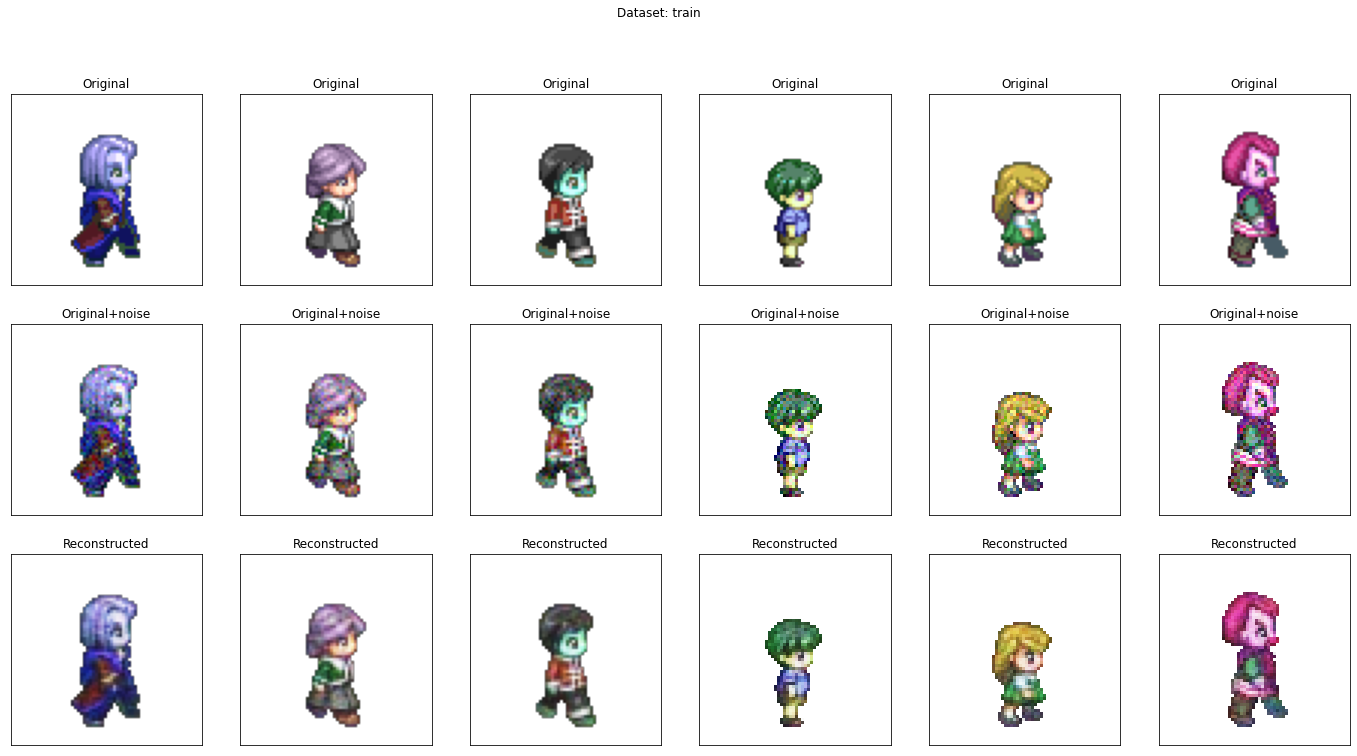

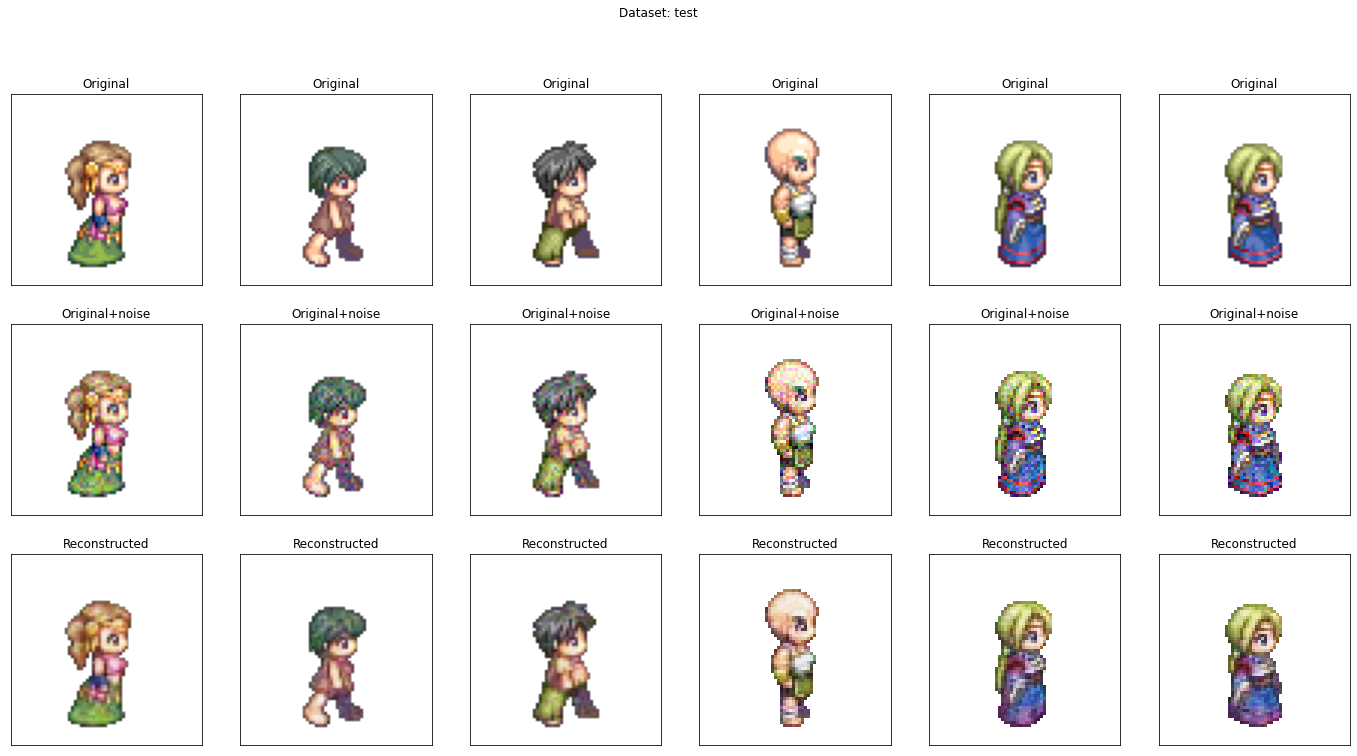

In [14]:
def show_images(denoiser, ds, ds_name):
    num_images = 6
    plt.figure(figsize=(24, 12))
    plt.suptitle(f"Dataset: {ds_name}")
    for i, (noisy_image, target_image) in ds.unbatch().take(num_images).batch(1).enumerate():
        i = i.numpy()
        encoded_image = denoiser.encoder(noisy_image)
        decoded_image = denoiser.decoder(encoded_image)
        decoded_image = tf.clip_by_value(decoded_image, -1., 1.)

        # display original, original+noise, then reconstructed
        images = [target_image, noisy_image, decoded_image]
        titles = ["Original", "Original+noise", "Reconstructed"]
        for j, (image, title) in enumerate(zip(images, titles)):
            ax = plt.subplot(3, num_images, num_images*j + i+1)
            plt.title(title)
            plt.imshow(tf.squeeze(image) * 0.5 + 0.5)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

show_images(model, train_ds, "train")
show_images(model, test_ds, "test")